In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyro
import pyro.distributions as dist
import torch
from pyro.nn import PyroModule
from cellij.core.models import MOFA


/Users/martin/miniconda3/envs/cellij/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create data
import os
import anndata
import muon as mu
import numpy as np
import pandas as pd

from importlib import resources
from collections import UserDict


obs = pd.read_csv(
    filepath_or_buffer=os.fspath("../data/cll_metadata.csv"),
    sep=",",
    index_col="Sample",
    encoding="utf-8",
)


modalities = {}

for ome in ["mrna"]:  # "drugs", "methylation", "mrna", "mutations"

    modalities[ome] = anndata.AnnData(
        pd.read_csv(
            filepath_or_buffer=os.fspath(f"../data/cll_{ome}.csv"),
            sep=",",
            index_col=0,
            encoding="utf-8",
        ).T
    )

mdata = mu.MuData(modalities)
mdata.obs = mdata.obs.join(obs)

/var/folders/5p/68w6m03x2v3d6q1vdbzf78f40000gn/T/ipykernel_38028/3685290522.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  modalities[ome] = anndata.AnnData(


In [4]:
model = MOFA(n_factors=50, sparsity_prior="spikeandslab")

In [5]:
model.add_data(data=mdata)

In [7]:
model.fit(likelihood="Normal",  epochs=1000, verbose_epochs=50)

Epoch      0:     3054616.64
Epoch     50:     2824557.37
Epoch    100:     2604776.77
Epoch    150:     2404555.13
Epoch    200:     2238193.56
Epoch    250:     2104219.28
Epoch    300:     1983400.48
Epoch    350:     1870902.43
Epoch    400:     1769171.42
Epoch    450:     1680508.04
Epoch    500:     1598764.07
Epoch    550:     1525168.12
Epoch    600:     1462676.07
Epoch    650:     1404286.27
Epoch    700:     1354525.43
Epoch    750:     1315644.63
Epoch    800:     1286484.45
Epoch    850:     1262186.27
Epoch    900:     1243868.56
Epoch    950:     1230723.38
Epoch   1000:     1226863.27


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
sns.heatmap(model._guide.locs.w.detach().numpy().squeeze(), center=0, cmap='RdBu_r')

<Axes: >

(50, 5000) (136, 50)


<Axes: >

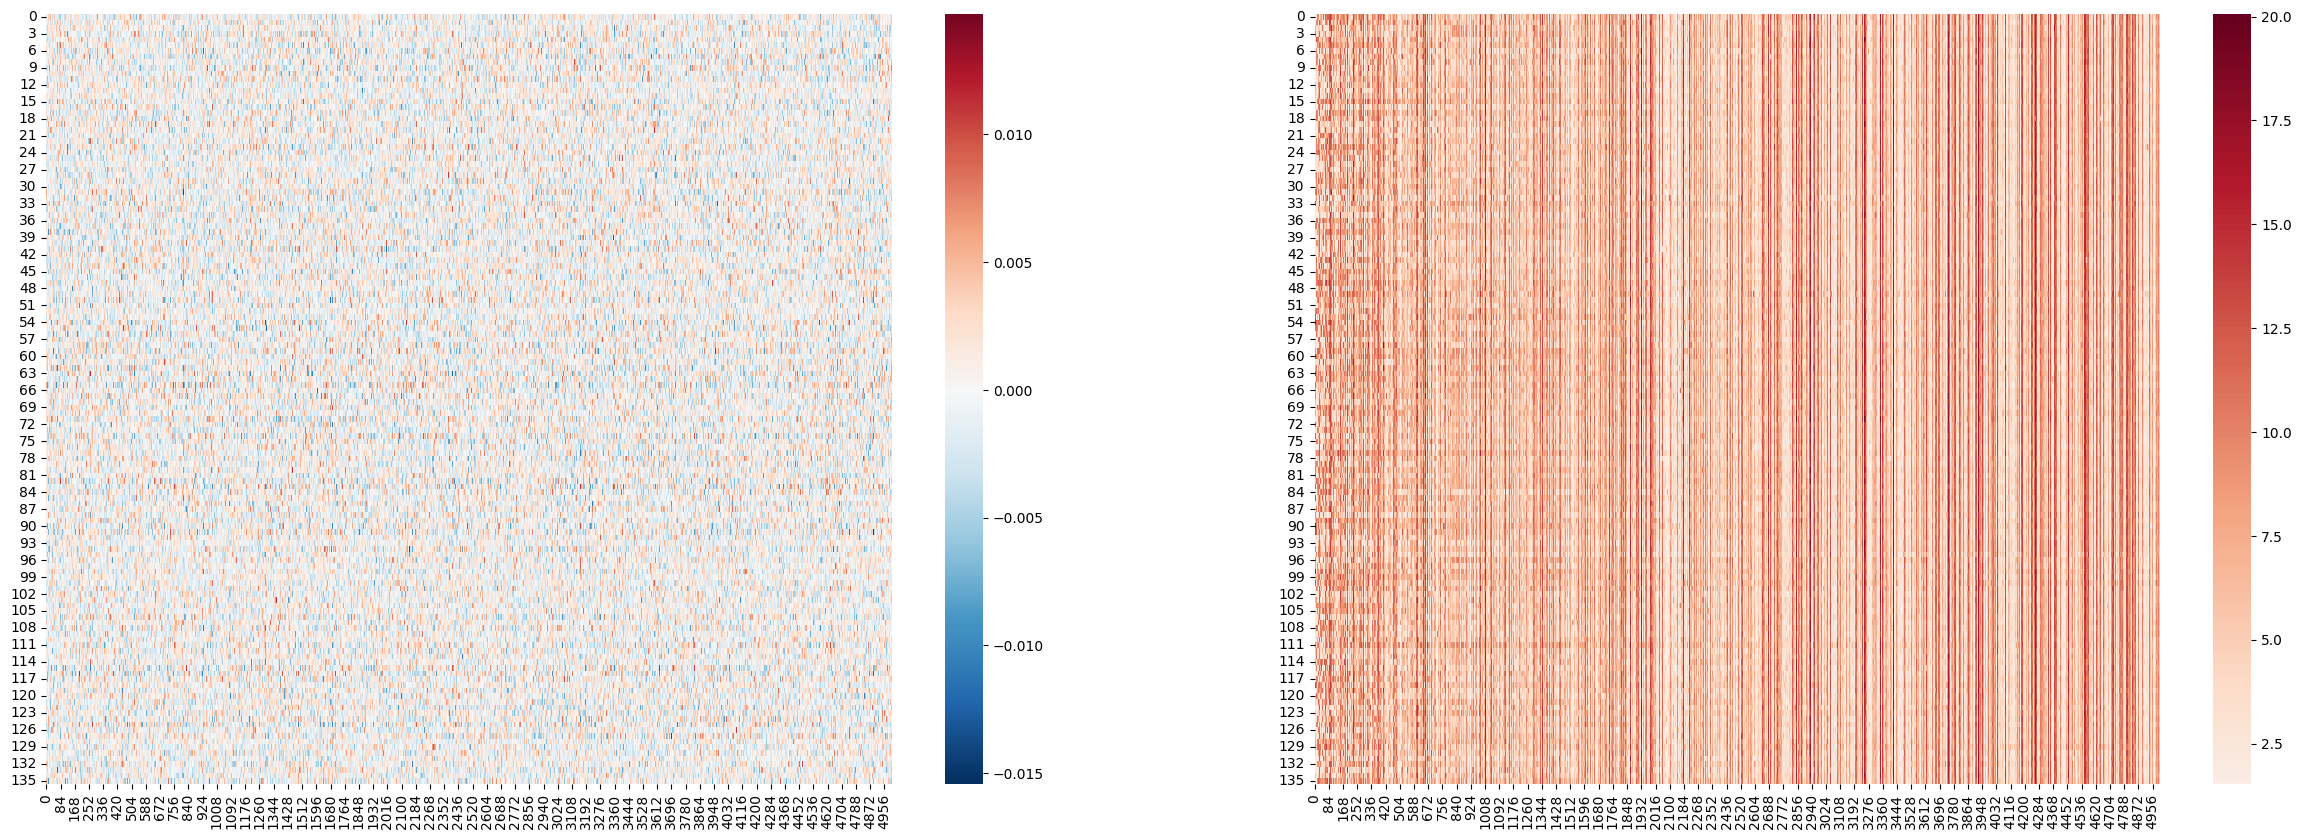

In [ ]:
w = model._guide.locs.w.detach().numpy().squeeze()
z = model._guide.locs.z.detach().numpy().squeeze()

print(w.shape, z.shape)

xhat = np.matmul(z, w)

fig, ax = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(xhat, center=0, cmap='RdBu_r', ax=ax[0])
sns.heatmap(mdata["mrna"].X, center=0, cmap='RdBu_r', ax=ax[1])